# Introduction

## Goals

* Measure the numerical precision of [fmriprep](https://github.com/nipreps/fmriprep)

## Methods

* Processed session `ses-001` of subject `sub-032633` in [SIMON dataset](https://portal.conp.ca/dataset?id=projects/SIMON-dataset)
* fmriprep options:
`--random-seed 1234 --fs-no-reconall --anat-only`
* fmriprep container was patched ([Dockerfile](https://github.com/glatard/fmriprep-1/blob/master/Dockerfile_fuzzy), build on Feb 24) with "fuzzy" libmath introducing random perturbations in the least-significant bit of floating-point numbers (inputs and outputs of functions manipulating floating-point numbers).
* This numerical perturbation is supposed to simulate the effect of OS updates

# Utils

In [1]:
import numpy as np
import nibabel as nib
import os.path as op

from nilearn import plotting as nilp
import matplotlib as mpl
from matplotlib import pyplot as plt
import sigdigits
import plotly.express as px
import scipy.stats as stats

In [19]:
sd_precision=sigdigits.Precision.Relative

def sigdig_cnh(array, base=2, axis=0):
    reference=np.mean(array,axis=axis,dtype=np.float64)
    s= sigdigits.significant_digits(array,
                                    reference=reference,
                                    probability=0.99,
                                    confidence=0.95,
                                    axis=axis,
                                    method=sigdigits.Method.CNH,
                                    precision=sd_precision,
                                    base=2)
    if base == 10:
        s2 = np.power(2,s)
        s10 = np.log10(s2)
        s = s10
        
    return np.array(s,dtype=np.float64)

def sigdig_general(array, base=2, axis=0):
    reference=np.mean(array,axis=axis,dtype=np.float64)
    s= sigdigits.significant_digits(array,
                                    reference=reference,
                                    probability=0.99,
                                    confidence=0.95,
                                    axis=axis,
                                    method=sigdigits.Method.General,
                                    precision=sd_precision,
                                    base=2)
    if base == 10:
        s2 = np.power(2,s)
        s10 = np.log10(s2)
        s = s10
        
    return np.array(s,dtype=np.float64)


def plot_array(array, cmap=mpl.cm.viridis):
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 8))
    ni_img = nib.Nifti1Image(array, nib.load(image_files[0]).affine)

    #fig.suptitle("(b) Distributions of significant bits averaged among 20 subjects on MNI space", fontsize=14)
    nilp.plot_img(ni_img, draw_cross=False, cmap=cmap, axes=axes,
                  annotate=False, black_bg=False, colorbar=True)

# Spatial normalization

## Significant digits

Using the functions defined above, we can now compute the number of significant digits in the images normalized to the MNI template.

Mean CNH:0.41230232870269334, General:1.4619690786404629


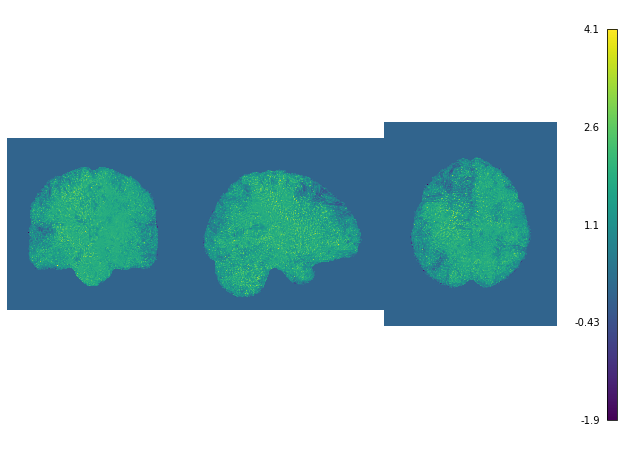

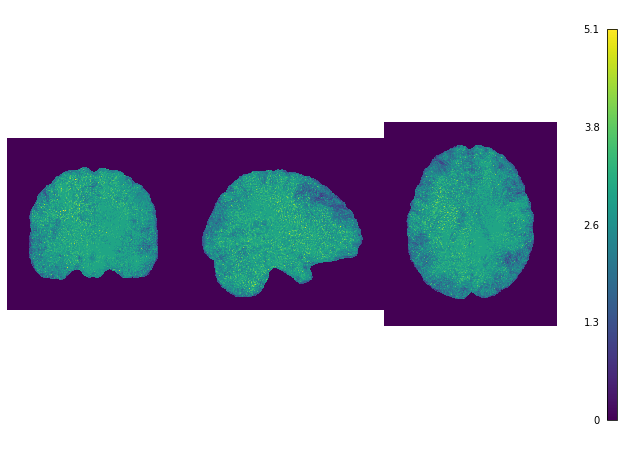

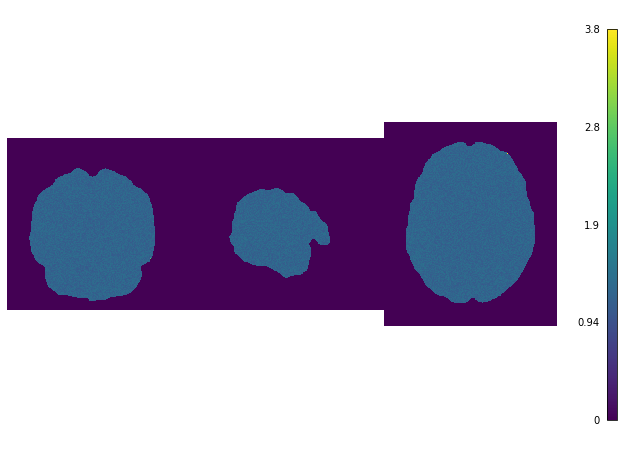

In [43]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
mask_name ="fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
n_samples = 3
condition = 'mca'

# Load brain mask
mask = nib.load(op.join(condition, "0", mask_name))

# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs_cnh = sigdig_cnh(array, base=10, axis=0)
sigdigs_gen = sigdig_general(array, base=10, axis=0)

# Mean sigdigits
m_cnh=np.nanmean(sigdigs_cnh)
m_gen=np.nanmean(sigdigs_gen)
print(f"Mean CNH:{m_cnh}, General:{m_gen}")

# Plot masked sigdigits (CNH)
mask_data = mask.get_fdata()
masked_sigdigs_cnh = np.where(mask_data>0, sigdigs_cnh, mask_data)
plot_array(masked_sigdigs_cnh)

# Plot masked sigdigits (General)
mask_data = mask.get_fdata()
masked_sigdigs_gen = np.where(mask_data>0, sigdigs_gen, mask_data)
plot_array(masked_sigdigs_gen)

# Diff between CNH and General
plot_array(np.abs(masked_sigdigs_cnh - masked_sigdigs_gen))

The average number of significant digits is 3.1 on a scale of 16.

## Visual differences

Apply brain mask of sample 0 to spatially-normalized samples:

In [9]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz\
               ${sample}.nii.gz
done

bash: line 4: ./fslmaths: No such file or directory
bash: line 4: ./fslmaths: No such file or directory
bash: line 4: ./fslmaths: No such file or directory


CalledProcessError: Command 'b'for sample in 0 1 2\ndo\n    FSLOUTPUTTYPE=NIFTI_GZ\\\n    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\\\n               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz\\\n               ${sample}.nii.gz\ndone\n'' returned non-zero exit status 127.

In [10]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [11]:
%%bash
convert -loop 0 0.png 1.png 2.png spatial-norm.gif

<img src="./spatial-norm.gif"/>

# Tissue class probabilities

## White matter

In [45]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz"

Mean sigdigits: CNH:1.1887901614710343, General:2.124764253339122


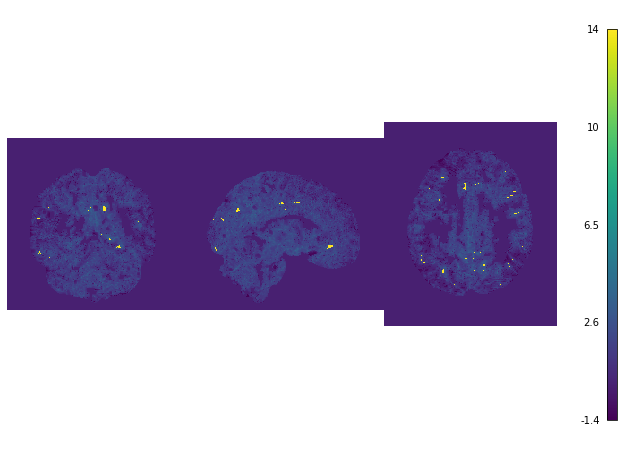

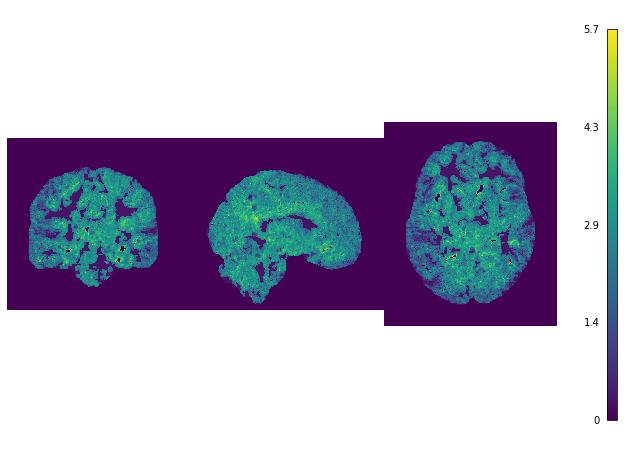

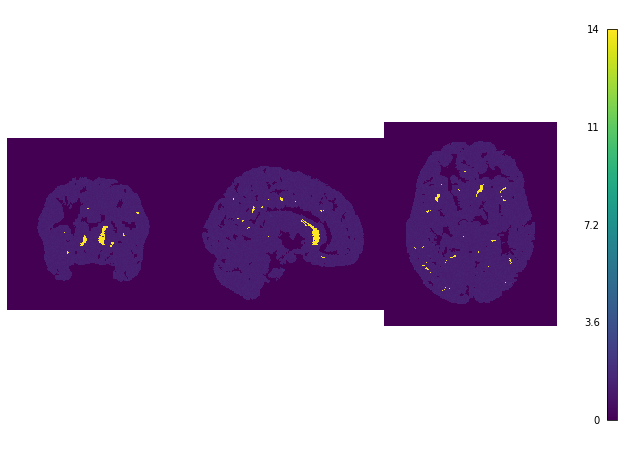

In [53]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs_cnh = sigdig_cnh(array, base=10, axis=0)
sigdigs_gen = sigdig_general(array, base=10, axis=0)

# Mean sigdigits
x = mask.get_fdata().astype('bool')
m_cnh=np.nanmean(sigdigs_cnh[x])
x = mask.get_fdata().astype('bool')
m_gen=np.nanmean(sigdigs_gen[x])
print(f"Mean sigdigits: CNH:{m_cnh}, General:{m_gen}")

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs_cnh = np.where(mask_data>0, sigdigs_cnh, mask_data)
plot_array(masked_sigdigs_cnh)

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs_gen = np.where(mask_data>0, sigdigs_gen, mask_data)
plot_array(masked_sigdigs_gen)

# Diff between CNH and General
diff = np.abs(masked_sigdigs_cnh - masked_sigdigs_gen)
plot_array(diff)

In [12]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz\
               ${sample}-WM.nii.gz
done

bash: line 4: ./fslmaths: No such file or directory
bash: line 4: ./fslmaths: No such file or directory
bash: line 4: ./fslmaths: No such file or directory


CalledProcessError: Command 'b'for sample in 0 1 2\ndo\n    FSLOUTPUTTYPE=NIFTI_GZ\\\n    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\\\n               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz\\\n               ${sample}-WM.nii.gz\ndone\n'' returned non-zero exit status 127.

In [15]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [16]:
%%bash
convert -loop 0 0-wm.png 1-wm.png 2-wm.png wm.gif

<img src="./wm.gif"/>

## Gray matter

In [47]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"

Mean sigdigits: CNH:1.1887901614710343, General:2.124764253339122


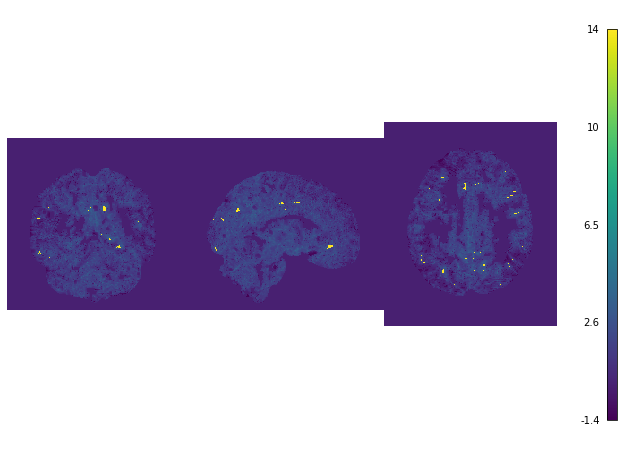

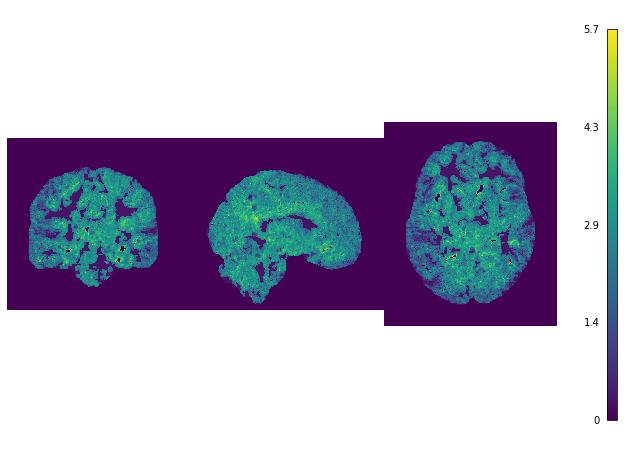

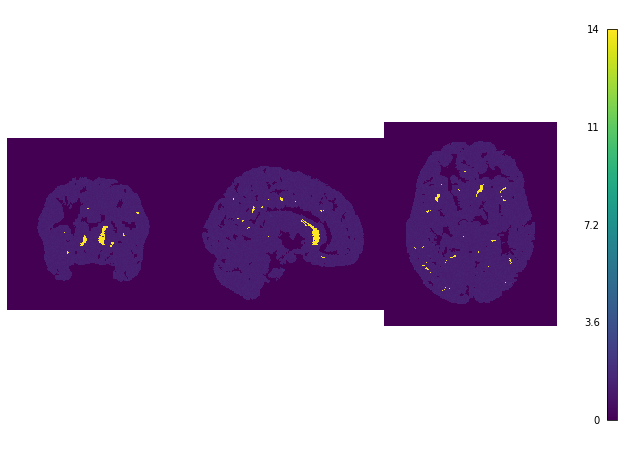

In [52]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs_cnh = sigdig_cnh(array, base=10, axis=0)
sigdigs_gen = sigdig_general(array, base=10, axis=0)

# Mean sigdigits
x = mask.get_fdata().astype('bool')
m_cnh=np.nanmean(sigdigs_cnh[x])
x = mask.get_fdata().astype('bool')
m_gen=np.nanmean(sigdigs_gen[x])
print(f"Mean sigdigits: CNH:{m_cnh}, General:{m_gen}")

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs_cnh = np.where(mask_data>0, sigdigs_cnh, mask_data)
plot_array(masked_sigdigs_cnh)

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs_gen = np.where(mask_data>0, sigdigs_gen, mask_data)
plot_array(masked_sigdigs_gen)

# Diff between CNH and General
diff = np.abs(masked_sigdigs_cnh - masked_sigdigs_gen)
plot_array(diff)


In [19]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz\
               ${sample}-GM.nii.gz
done

In [20]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [21]:
%%bash
convert -loop 0 0-gm.png 1-gm.png 2-gm.png gm.gif

<img src="./gm.gif"/>

# IEEE (non-perturbed) samples

Let's check that significant digits are maximal for IEEE samples. We changed the following parameters in data processing:
* fmriprep: same as before (including `--random-seed 1234`
* verificarlo: `VFC_BACKENDS='libinterflop_ieee.so'`

## Resampled images

In [29]:
condition = 'ieee'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 2

In [30]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

FileNotFoundError: No such file or no access: 'ieee/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

In [31]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [32]:
# Mean sigdigits
np.nanmean(sigdigs)

3.221775898215765

FileNotFoundError: No such file or no access: 'ieee/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

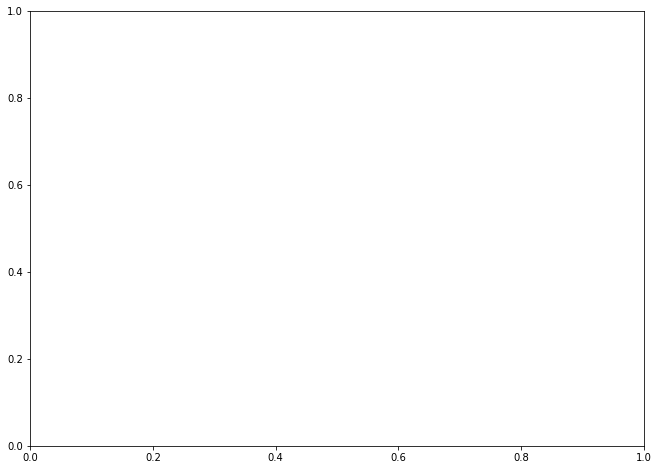

In [33]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

oops... Let's check what happened, we're supposed to have identical results in this case. Maybe an issue with how the random seed is set?

# Random seeds

Let's compare the variability obtained with numerical perturbations to the one resulting from using different random seeds (wip).

## Resampled images

In [34]:
condition = 'seed'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 3

In [35]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

FileNotFoundError: No such file or no access: 'seed/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

In [36]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [37]:
# Mean sigdigits
np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

TypeError: _mean_dispatcher() got an unexpected keyword argument 'where'

FileNotFoundError: No such file or no access: 'seed/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

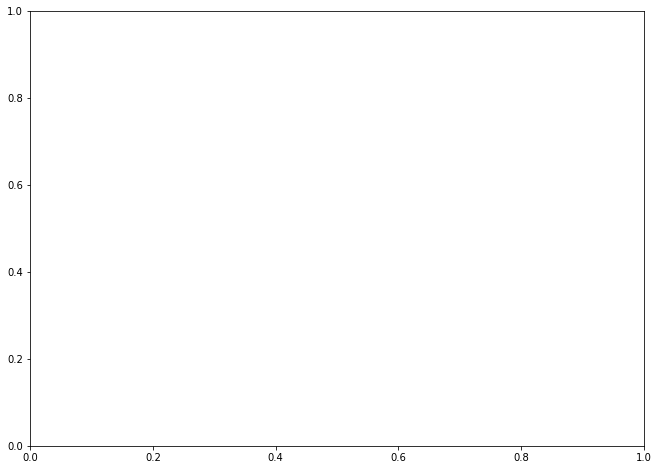

In [38]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [39]:
# Next steps

* Investigate why `--random-seed` doesn't seem to lead to deterministic results 
* Make more samples per dataset
* Add more sessions / subjects
* Extend to functional pipeline
* Conclude on acceptab

SyntaxError: invalid syntax (<ipython-input-39-d38dd8257de3>, line 3)